In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import tensorflow as tf
import gc
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Activation, BatchNormalization, Dropout, LSTM, ConvLSTM2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, LSTM, ConvLSTM2D, Lambda, Reshape, BatchNormalization, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint,TensorBoard,TerminateOnNaN, LearningRateScheduler, CSVLogger
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.layers import Lambda, Reshape, DepthwiseConv2D, ZeroPadding2D, Add, MaxPooling2D,Activation, Flatten, Conv2D, Dense, Input, Dropout, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental import preprocessing
from keras.applications import imagenet_utils
from tensorflow.keras import layers
!pip install tensorflow-addons
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
import random
import keras
import shutil
import pathlib
import itertools
import cv2
import os
import matplotlib.image as mpimg
import seaborn as sns

In [27]:
# pip install typing-extensions==4.6.0


In [28]:
# pip install scikit-learn

In [29]:
train_dir = '/content/drive/MyDrive/Brain tumor mugilan/Datasets/Training/'
test_dir = '/content/drive/MyDrive/Brain tumor mugilan/Datasets/Testing/'

In [30]:
for dirpath, dirnames, filenames in os.walk(train_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in '/content/drive/MyDrive/Brain tumor mugilan/Datasets/Training/'.
There are 0 directories and 826 images in '/content/drive/MyDrive/Brain tumor mugilan/Datasets/Training/glioma_tumor'.
There are 0 directories and 395 images in '/content/drive/MyDrive/Brain tumor mugilan/Datasets/Training/no_tumor'.
There are 0 directories and 822 images in '/content/drive/MyDrive/Brain tumor mugilan/Datasets/Training/meningioma_tumor'.
There are 0 directories and 827 images in '/content/drive/MyDrive/Brain tumor mugilan/Datasets/Training/pituitary_tumor'.


In [31]:
for dirpath, dirnames, filenames in os.walk(test_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 4 directories and 0 images in '/content/drive/MyDrive/Brain tumor mugilan/Datasets/Testing/'.
There are 0 directories and 74 images in '/content/drive/MyDrive/Brain tumor mugilan/Datasets/Testing/pituitary_tumor'.
There are 0 directories and 105 images in '/content/drive/MyDrive/Brain tumor mugilan/Datasets/Testing/no_tumor'.
There are 0 directories and 100 images in '/content/drive/MyDrive/Brain tumor mugilan/Datasets/Testing/glioma_tumor'.
There are 0 directories and 115 images in '/content/drive/MyDrive/Brain tumor mugilan/Datasets/Testing/meningioma_tumor'.


In [32]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");
  print(f"Image shape: {img.shape}")
  return img

Image shape: (274, 248, 3)


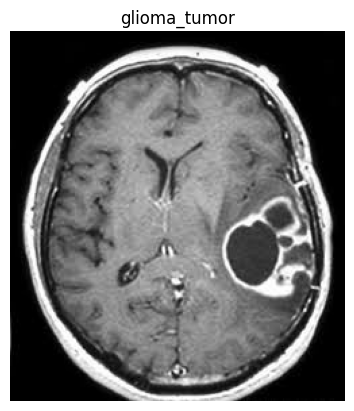

In [33]:
img = view_random_image(target_dir=test_dir,
                        target_class="glioma_tumor")

In [34]:
EPOCHS = 5
from math import floor
N_FOLDS = 5
INIT_LR = 1e-3
T_BS = 16
V_BS = 16
decay_rate = 0.95
decay_step = 1
IMAGE_SIZE = [224,224]

In [35]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

def augment_image(image, label):
    # Apply augmentation transformations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)

    # Apply the width and height shifts
    width_shift = tf.random.uniform([], -0.2, 0.2) * tf.cast(tf.shape(image)[1], tf.float32)
    height_shift = tf.random.uniform([], -0.2, 0.2) * tf.cast(tf.shape(image)[0], tf.float32)
    image = tfa.image.translate(image, [width_shift, height_shift])

    return image, label

In [36]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 batch_size=32,
                                                                 image_size=IMAGE_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMAGE_SIZE,
                                                                shuffle=False)

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


In [37]:
# Apply augmentation to the training dataset using the map function
train_dataset_augmented = train_data.map(augment_image)

In [38]:
def Combined_model():
    # Input layer
    input_layer = Input(shape=(224, 224, 3))

    # Base VGG19 model as a feature extractor
    baseModel = VGG19(weights=None, include_top=False, input_tensor=input_layer)

    # Load the weights from the local file (specify the path)
    baseModel.load_weights('/content/drive/MyDrive/Brain tumor mugilan/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

    # Freeze the layers of the VGG19 model
    for layer in baseModel.layers:
        layer.trainable = False

    x = baseModel.output

    # LSTM layer
    x = Reshape((49, 512))(x)
    x = LSTM(512, activation="relu", return_sequences=True, trainable=False)(x)
    x = BatchNormalization()(x)

    # FC layer
    x = Flatten(name="flatten")(x)

    # fc1 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)

    # fc2 layer
    x = Dense(units=4096, activation='relu')(x)
    x = BatchNormalization()(x)

    # Output layer
    output = Dense(units=4, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output)
    opt = Adam(lr=1e3)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

    return model

# Create the model
model = Combined_model()

# Print the model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [39]:
checkpoint = [ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy',mode='max',verbose=1,save_best_only=True,save_weights_only=True),
             LearningRateScheduler(lambda epoch : INIT_LR * pow(decay_rate, floor(epoch / decay_step)))]
earlystop = EarlyStopping(monitor='accuracy', min_delta=0, patience=15, verbose=1, mode='max')

In [59]:
history = model.fit(train_dataset_augmented,
                    epochs=25,
                    steps_per_epoch=len(train_dataset_augmented),
                    validation_data = test_data,
                    callbacks=[checkpoint])

Epoch 1/25
90/90 [==============================] - ETA: 0s - loss: 0.4002 - accuracy: 0.8735
Epoch 1: val_accuracy did not improve from 0.72589
90/90 [==============================] - 29s 304ms/step - loss: 0.4002 - accuracy: 0.8735 - val_loss: 3.0043 - val_accuracy: 0.6447 - lr: 0.0010
Epoch 2/25
90/90 [==============================] - ETA: 0s - loss: 0.3780 - accuracy: 0.8878
Epoch 2: val_accuracy did not improve from 0.72589
90/90 [==============================] - 28s 304ms/step - loss: 0.3780 - accuracy: 0.8878 - val_loss: 3.7576 - val_accuracy: 0.6701 - lr: 9.5000e-04
Epoch 3/25
90/90 [==============================] - ETA: 0s - loss: 0.3268 - accuracy: 0.8878
Epoch 3: val_accuracy did not improve from 0.72589
90/90 [==============================] - 29s 311ms/step - loss: 0.3268 - accuracy: 0.8878 - val_loss: 4.0670 - val_accuracy: 0.6701 - lr: 9.0250e-04
Epoch 4/25
90/90 [==============================] - ETA: 0s - loss: 0.3020 - accuracy: 0.8986
Epoch 4: val_accuracy did no

In [60]:
model.load_weights('/content/best_model.h5')
_, accuracy = model.evaluate(test_data)
print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

13/13 [==============================] - 3s 182ms/step - loss: 2.7350 - accuracy: 0.7589
Validation accuracy: 75.89%


In [61]:
pred_probs = model.predict(test_data, verbose=1)

13/13 [==============================] - 2s 178ms/step


In [62]:
pred_classes = pred_probs.argmax(axis=1)

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [63]:
target_names = ['Glioma', 'Meningioma', 'No Tumor','Pituitary']
print(classification_report(y_labels,
                            pred_classes,
                            target_names=target_names, digits=4))

              precision    recall  f1-score   support

      Glioma     0.7838    0.2900    0.4234       100
  Meningioma     0.7013    0.9391    0.8030       115
    No Tumor     0.7394    1.0000    0.8502       105
   Pituitary     0.9344    0.7703    0.8444        74

    accuracy                         0.7589       394
   macro avg     0.7897    0.7499    0.7302       394
weighted avg     0.7762    0.7589    0.7270       394



In [64]:
cm = confusion_matrix(y_labels,pred_classes)

TP = cm[0, 0]
TN = cm[1:, 1:].sum()
FP = cm[0, 1:].sum()
FN = cm[1:, 0].sum()

Population = TN+FN+TP+FP
spesificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print("True Positives:", TP)
print("False Positives:", FP)
print("True Negatives:", TN)
print("False Negatives:", FN)
print("Specificity:", spesificity)
print("Sensitivity:", sensitivity)

True Positives: 29
False Positives: 71
True Negatives: 286
False Negatives: 8
Specificity: 0.8011204481792717
Sensitivity: 0.7837837837837838


In [65]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(20, 20), text_size=15, norm=False, savefig=False):

  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.grid(False)

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

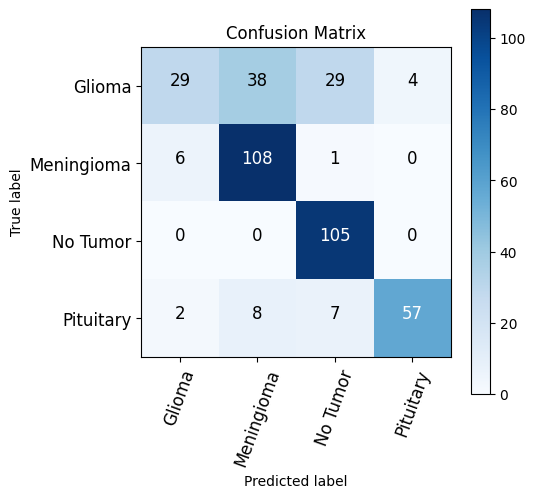

In [66]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=target_names,
                      figsize=(5, 5),
                      text_size=12,
                      norm=False,
                      savefig=True)

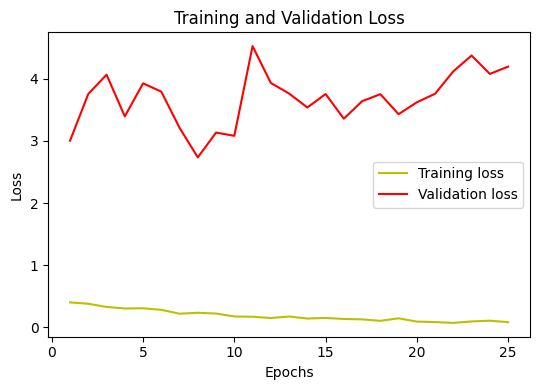

In [67]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(5.5, 4))

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(False)

plt.tight_layout()
plt.show()

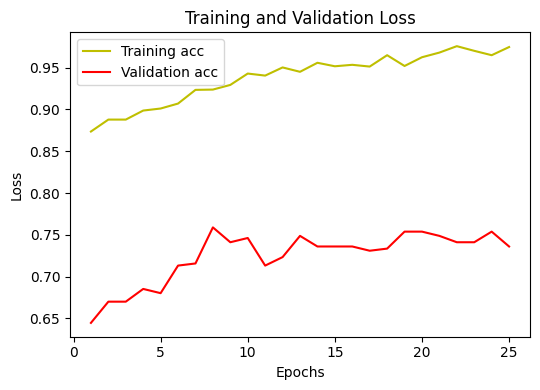

In [68]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(5.5, 4))

plt.plot(epochs, loss, 'y', label='Training acc')
plt.plot(epochs, val_loss, 'r', label='Validation acc')
plt.title('Training and Validation Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(False)

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 30ms/step
Predicted class: Pituitary


<h3 style='color:blue;'>Severity: 99.06%</h3>

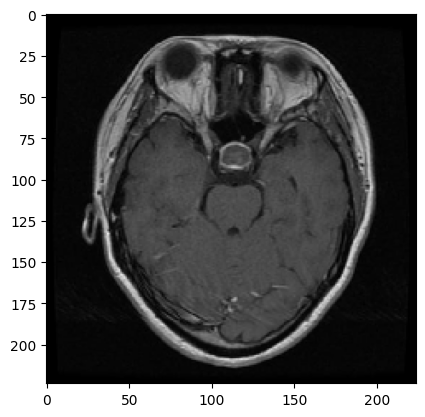

In [121]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.vgg19 import preprocess_input
from IPython.display import display, Markdown
import matplotlib.pyplot as plt  # Added import for matplotlib

# Load the image
img_path = '/content/drive/MyDrive/Brain tumor mugilan/Datasets/Training/pituitary_tumor/p (10).jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)  # Preprocess the image

# Use the trained model to predict
pred_probs = model.predict(x)
pred_class = np.argmax(pred_probs[0])  # Get the index of the highest probability

# Display the predicted class
target_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
predicted_class_name = target_names[pred_class]
print("Predicted class:", predicted_class_name)

if predicted_class_name != 'No Tumor':
    Severity = pred_probs[0][pred_class]
    markdown_text2 = f"<h3 style='color:blue;'>Severity: {Severity*100:.2f}%</h3>"
    display(Markdown(markdown_text2))

plt.imshow(img)
plt.show()


1/1 [==============================] - 0s 25ms/step
Predicted class: Meningioma


<h3 style='color:blue;'>Severity: 99.40%</h3>

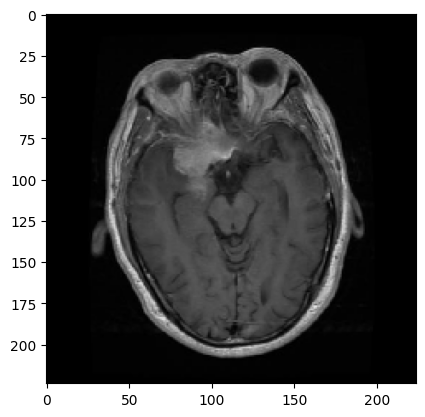

In [122]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.vgg19 import preprocess_input
from IPython.display import display, Markdown
import matplotlib.pyplot as plt  # Added import for matplotlib

# Load the image
img_path = '/content/drive/MyDrive/Brain tumor mugilan/Datasets/Training/meningioma_tumor/m (105).jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)  # Preprocess the image

# Use the trained model to predict
pred_probs = model.predict(x)
pred_class = np.argmax(pred_probs[0])  # Get the index of the highest probability

# Display the predicted class
target_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
predicted_class_name = target_names[pred_class]
print("Predicted class:", predicted_class_name)

if predicted_class_name != 'No Tumor':
    Severity = pred_probs[0][pred_class]
    markdown_text2 = f"<h3 style='color:blue;'>Severity: {Severity*100:.2f}%</h3>"
    display(Markdown(markdown_text2))

plt.imshow(img)
plt.show()


1/1 [==============================] - 0s 43ms/step
Predicted class: Glioma


<h3 style='color:blue;'>Severity: 79.38%</h3>

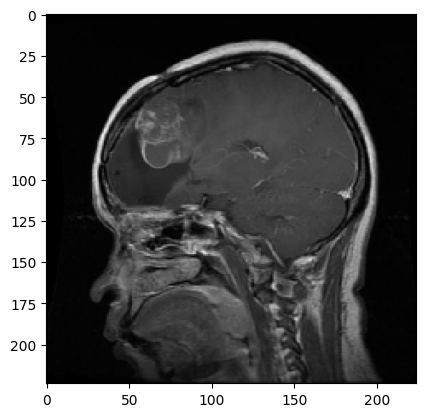

In [123]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.vgg19 import preprocess_input
from IPython.display import display, Markdown
import matplotlib.pyplot as plt  # Added import for matplotlib

# Load the image
img_path = '/content/drive/MyDrive/Brain tumor mugilan/Datasets/Training/glioma_tumor/gg (124).jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)  # Preprocess the image

# Use the trained model to predict
pred_probs = model.predict(x)
pred_class = np.argmax(pred_probs[0])  # Get the index of the highest probability

# Display the predicted class
target_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
predicted_class_name = target_names[pred_class]
print("Predicted class:", predicted_class_name)

if predicted_class_name != 'No Tumor':
    Severity = pred_probs[0][pred_class]
    markdown_text2 = f"<h3 style='color:blue;'>Severity: {Severity*100:.2f}%</h3>"
    display(Markdown(markdown_text2))

plt.imshow(img)
plt.show()


1/1 [==============================] - 0s 25ms/step
Predicted class: No Tumor


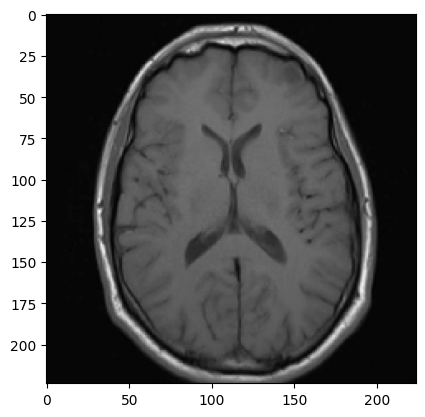

In [124]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.vgg19 import preprocess_input
from IPython.display import display, Markdown
import matplotlib.pyplot as plt  # Added import for matplotlib

# Load the image
img_path = '/content/drive/MyDrive/Brain tumor mugilan/Datasets/Training/no_tumor/3.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)  # Preprocess the image

# Use the trained model to predict
pred_probs = model.predict(x)
pred_class = np.argmax(pred_probs[0])  # Get the index of the highest probability

# Display the predicted class
target_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
predicted_class_name = target_names[pred_class]
print("Predicted class:", predicted_class_name)

if predicted_class_name != 'No Tumor':
    Severity = pred_probs[0][pred_class]
    markdown_text2 = f"<h3 style='color:blue;'>Severity: {Severity*100:.2f}%</h3>"
    display(Markdown(markdown_text2))

plt.imshow(img)
plt.show()
